# Purchasing Power Parity as a Value Strategy in FX

In this notebook you will apply a few things you learned in our Python lecture [FinanceHub's Python lectures](https://github.com/Finance-Hub/FinanceHubMaterials/tree/master/Python%20Lectures):

* You will use and manipulate different kinds of variables in Python such as text variables, booleans, date variables, floats, dictionaries, lists, list comprehensions, etc.;
* We will also use `Pandas.DataFrame` objects and methods which are very useful in manipulating financial time series;
* You will use if statements and loops, and;
* You will use [FinanceHub's Bloomberg tools](https://github.com/Finance-Hub/FinanceHub/tree/master/bloomberg) for fetching data from a Bloomberg terminal. If you are using this notebook within BQNT, you may want to use BQL for getting the data.

## Basic imports

In [2]:
from scipy import stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from bloomberg import BBG
bbg = BBG() # because BBG is a class, we need to create an instance of the BBG class wihtin this notebook, here deonted by bbg

## Purchasing Power Parity as a value measure in FX

Currencies also have their garden-variety value indicators. Among these, purchasing power parity (PPP) has the most intuitive appeal. Absolute PPP theory states that all tradable products must sell at the same price. It follows that an exchange rate XXXYYY - which is the number of units of the YYY currency needed to buy one unit of the XXX currency units - is the ratio of the price index in the monetary area using currency XXX to the price index in the monetary area using currency YYY.

PPP works along the lines of the [Big Mac Index](https://www.economist.com/news/2020/01/15/the-big-mac-index) which compares the price of a Big Mac across different countries. Like PPP, the idea is that in the long run exchange rates should move towards the rate that would equalise the prices of an identical basket of goods and services (in this case, a hamburger) in any two monetary areas.

So, if the exchange rate $Spot_{XXXYYY}$ is high relative to what PPP (or the Big Mac Index) dictates, it means that we get more units of currency YYY per unit of currency XXX than what is suggested by an identical basket of goods and services. In that case, instead of buying the basket of goods and services (or a Big Mac) by the price $P_{XXX}$ in currency XXX, it is cheaper to buy it for $P_{YYY}$ in currency YYY given that $P_{XXX} > P_{YYY}/Spot_{XXXYYY}$. By that metric, YYY is cheap vs. XXX and as people try to take advantage of such price differentials between $P_{XXX}$ and $P_{YYY}/Spot_{XXXYYY}$, they will buy YYY and sell XXX, causing the $Spot_{XXXYYY}$ to fall. Hence, when $Spot_{XXXYYY}$ is high relative to what PPP (or the Big Mac Index) dictates, we want to get short XXX and long YYY and therefore we want to get short the cross XXXYYY.

#### Real Exchnage rate (RER)

The real exchnage rate (RER) between two currencies is the product of the nominal exchange rate $Spot_{XXXYYY}$, which gives the YYY cost of a XXX unit, and the ratio of prices between the two countries:

$$
RER_{XXXYYY} = Spot_{XXXYYY} \times \frac{P_{XXX}}{P_{YYY}}
$$

If the basket of goods and services (or the Big Mac) costs the same number of units of currency YYY in both monetary areas, then $RER_{XXXYYY}=1$ and the $Spot_{XXXYYY}$ is in line with PPP. If the basket of goods and services (or the Big Mac) costs more in the currency area of XXX than of YYY, then $RER_{XXXYYY}>1$ and we will say that XXX is overvalued versus YYY. If the basket of goods and services (or the Big Mac) costs less in the currency area of XXX than of YYY, then $RER_{XXXYYY}<1$ and we will say that XXX is cheap versus YYY.

#### OECD PPP

The OECD calculates for us the PPP price ratio of a basket of goods and services. The final product list covers around 3,000 consumer goods and services, 30 occupations in government, 200 types of equipment goods and about 15 construction projects. For more information see [OECD website](http://www.oecd.org/std/purchasingpowerparities-frequentlyaskedquestionsfaqs.htm) and for details on PPP calculations see [Chapter 12 on the OECD manual](http://www.oecd.org/sdd/prices-ppp/PPP%20manual%20revised%202012.pdf).

The OECD always publishes the ratio vs. the US price index, i.e., as $P_{XXX}/P_{USD}$, so they are always quoted as USDXXX which gives the XXX cost of one USD. Hence, in practice, we calculate

$$
RER_{XXXYYY} = Spot_{XXXYYY} \times \frac{P_{XXX}/P_{USD}}{P_{YYY}/P_{USD}}
$$

#### PPP value

Given what we discussed above, the $RER_{XXXYYY}$ itself can be used as a metric of value for comparing XXX vs. YYY with a low $RER_{XXXYYY}$ suggesting that XXX is cheap vs. YYY. It is common to define value in FX as:
$$
Value_{XXXYYY} = \ln(RER_{XXXYYY})
$$
just so we have a percentage measure of how over/undervalue the currency XXX is vs. YYY.

Note that this value metric can be calculated for any point in time $t$, so it is in fact indexed by $t$, i.e. $Value_{XXXYYY,t}$. Certain value implementations, particularly in time series format, may also subtract the mean or standardize the metric using time series z-scores, sometime winsorizing them as well.

#### Inverse quotes

Before we start, note that some currencies like the EUR are quoted as EURUSD while currencies like CAD are quoted as USDCAD. The Bloomberg field INVERSE_QUOTED tells as if the quote as USDXXX (INVERSE_QUOTED = N) or as XXXUSD (INVERSE_QUOTED = Y). We could simply use the XXXYYY tickers on Bloomberg but they are not that reliable. It's better to stick to the standard quote of the currency.

In [22]:
ccy1 = 'SEK'
ccy2 = 'EUR'

inverse_quote = bbg.fetch_contract_parameter(securities=ccy1 + ' Curncy', field='INVERSE_QUOTED')


inverse_quote = bbg.fetch_contract_parameter(securities=ccy1 + ' Curncy', field='INVERSE_QUOTED')
ccy1_quote = ccy1 + 'USD' if inverse_quote.iloc[0,0]=='Y' else 'USD' + ccy1
print('The %s is quoted as %s' % (ccy1,ccy1_quote))

inverse_quote = bbg.fetch_contract_parameter(securities=ccy2 + ' Curncy', field='INVERSE_QUOTED')
ccy2_quote = ccy2 + 'USD' if inverse_quote.iloc[0,0]=='Y' else 'USD' + ccy2
print('The %s is quoted as %s' % (ccy2,ccy2_quote))

spot_rates = bbg.fetch_contract_parameter(securities=[ccy1 + ' Curncy',ccy2 + ' Curncy'], field='PX_LAST')

if ccy1_quote[:3] == 'USD' and ccy2_quote[:3] == 'USD':
    spot_fx =  spot_rates.loc[ccy2 + ' Curncy','PX_LAST']/spot_rates.loc[ccy1 + ' Curncy','PX_LAST']
elif ccy1_quote[:3] == 'USD' and ccy2_quote[:3] != 'USD':
    spot_fx =  (1/spot_rates.loc[ccy2 + ' Curncy','PX_LAST'])/spot_rates.loc[ccy1 + ' Curncy','PX_LAST']
elif ccy1_quote[:3] != 'USD' and ccy2_quote[:3] == 'USD':
    spot_fx =  spot_rates.loc[ccy2 + ' Curncy','PX_LAST']/(1/spot_rates.loc[ccy1 + ' Curncy','PX_LAST'])
else:
    spot_fx =  spot_rates.loc[ccy1 + ' Curncy','PX_LAST']/spot_rates.loc[ccy2 + ' Curncy','PX_LAST']

print('The %s spot rate is %s' % (ccy1 + ccy2,spot_fx))

The SEK is quoted as USDSEK
The EUR is quoted as EURUSD
The SEKEUR spot rate is 0.09521664428837485


## Calculating value in FX

Let's start with the EUR vs. SEK example:

In [24]:
country_dic = {
'AUD' : 'AS',
'CAD' : 'CA',
'CHF' : 'SZ',
'EUR' : 'EUAR',
'GBP' : 'UK',
'JPY' : 'JN',
'NOK' : 'NO',
'NZD' : 'NZ',
'SEK' : 'SW',
 'USD' : 'US'
}

P_ccy1 = bbg.fetch_contract_parameter(securities='PPP ' + country_dic[ccy1.replace(' Curncy','')] + ' Index',
                                      field='PX_LAST')
P_ccy2 = bbg.fetch_contract_parameter(securities='PPP ' + country_dic[ccy2.replace(' Curncy','')] + ' Index',
                                      field='PX_LAST')

RER = spot_fx * P_ccy1.iloc[0,0]/P_ccy2.iloc[0,0]
print('The %s real exchange rate is %s' % (ccy1 + ccy2,RER))

The SEKEUR RER is 1.1887509083017893


## Time series case

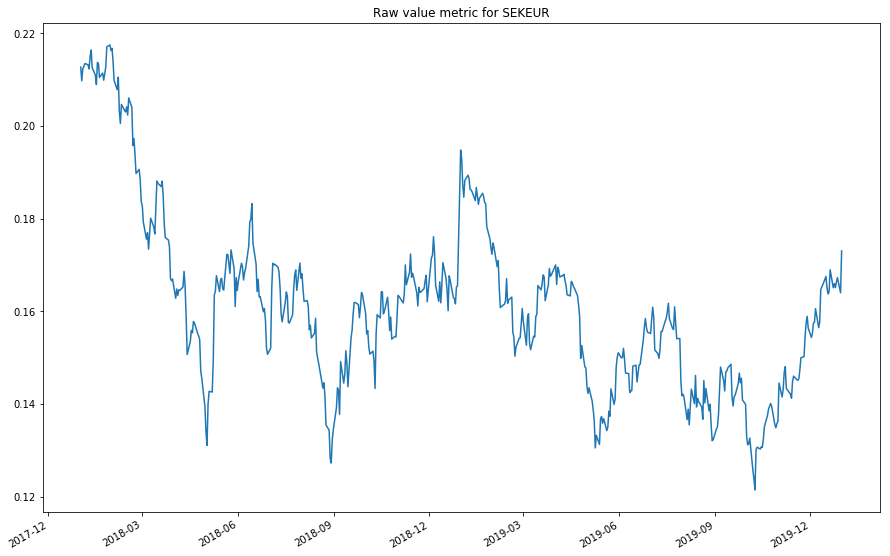

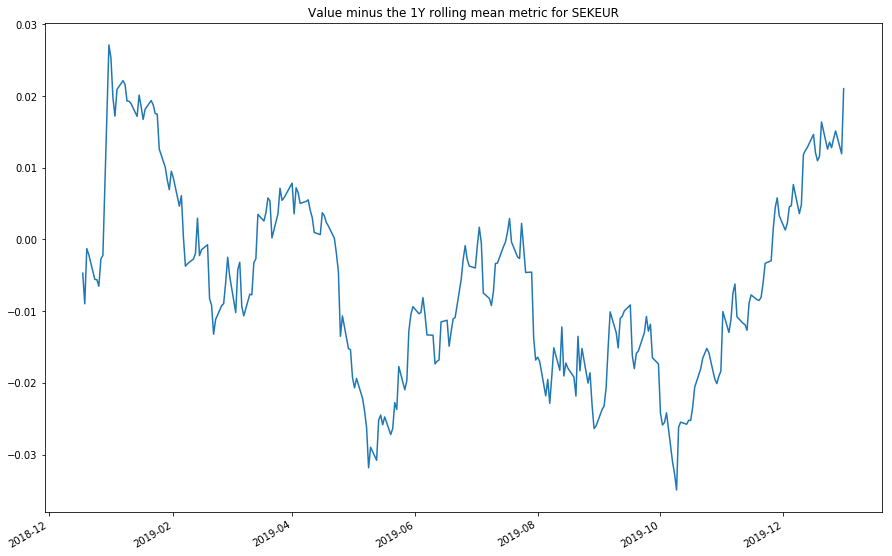

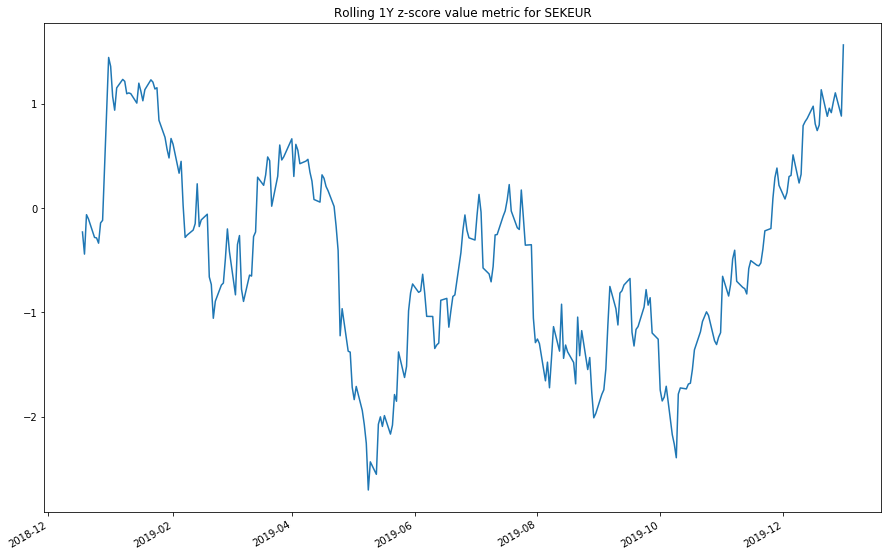

In [42]:
bbg_data = bbg.fetch_series(securities=[ccy1 + ' Curncy',ccy2 + ' Curncy',
                                        'PPP ' + country_dic[ccy1.replace(' Curncy','') ] + ' Index',
                                        'PPP ' + country_dic[ccy2.replace(' Curncy','') ] + ' Index'],
                      fields='PX_LAST',
                      startdate='2017-12-31',
                      enddate='2019-12-31')
bbg_data = bbg_data.fillna(method='ffill')


if ccy1_quote[:3] == 'USD' and ccy2_quote[:3] == 'USD':
    spot_fx =  bbg_data[ccy2 + ' Curncy']/bbg_datac[ccy1 + ' Curncy']
elif ccy1_quote[:3] == 'USD' and ccy2_quote[:3] != 'USD':
    spot_fx =  (1/bbg_data[ccy2 + ' Curncy'])/bbg_data[ccy1 + ' Curncy']
elif ccy1_quote[:3] != 'USD' and ccy2_quote[:3] == 'USD':
    spot_fx =  bbg_data[ccy2 + ' Curncy']/(1/bbg_data[ccy1 + ' Curncy'])
else:
    spot_fx =  bbg_data[ccy1 + ' Curncy']/bbg_data[ccy2 + ' Curncy']

RER = spot_fx * bbg_data['PPP ' + country_dic[ccy1.replace(' Curncy','') ] + ' Index']/bbg_data['PPP ' + country_dic[ccy2.replace(' Curncy','') ] + ' Index']
value = np.log(RER)
value.plot(title='Raw value metric for %s' % ccy1 + ccy2,figsize=(15,10))
plt.show()

zero_mean = value - value.rolling(window=252).mean()
zero_mean.plot(title='Value minus the 1Y rolling mean metric for %s' % ccy1 + ccy2,figsize=(15,10))
plt.show()

zscore = (value - value.rolling(window=252).mean())/value.rolling(window=252).std()
zscore.plot(title='Rolling 1Y z-score value metric for %s' % ccy1 + ccy2,figsize=(15,10))
plt.show()

## Exercises

#### Beginners

Try to calculate value for a few currencies and create some code to run some regressions like on future returns on the value metric or the change in the value signals we discussed above. Also, think about the case where the value signal (or the change in value signal) is supposed to predict direction (so if the underlying is going up or down) and not predict the actual realized future returns.

#### Intermediate

Calculate a time series FX value strategy as in  [Baz, Granger, Harvey, Le Roux, and Rattray (2015)](https://www.cmegroup.com/education/files/dissecting-investment-strategies-in-the-cross-section-and-time-series.pdf) or in [Baltas (2017)](https://doi.org/10.1016/B978-1-78548-201-4.50013-1)


#### Advanced

Create a class to calculate value for any cross XXXYYY.

#### Jedi Master

Carry out the Advanced task above and make a contribution to [FinanceHub's signals class](https://github.com/Finance-Hub/FinanceHub/tree/master/signals).